In [142]:
import pandas as pd
from sklearn.model_selection import train_test_split

data = pd.read_csv("data_tutorial.csv")
train, test = train_test_split(data, test_size = 0.22, random_state = 123)

In [143]:
#Word Count
train["wordcount"] = train["body"].apply(lambda n: len(n.split()))
train.wordcount.sum()
train.groupby("category").describe()

Unnamed: 0                                                  \
                   count         mean          std   min     25%     50%   
category                                                                   
ADHS              5620.0  3895.263345  2272.950191  20.0  1957.0  3875.5   
depression_de     5636.0  4093.672818  2349.496213   1.0  2088.5  4062.5   

                                wordcount                                    \
                   75%      max     count       mean         std  min   25%   
category                                                                      
ADHS           5806.25  13982.0    5620.0  69.145196   93.786497  1.0  17.0   
depression_de  6120.25   8215.0    5636.0  81.476757  108.899217  1.0  15.0   

                                    
                50%    75%     max  
category                            
ADHS           40.0   85.0  1346.0  
depression_de  46.0  106.0  1179.0

In [144]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score

pipeline = Pipeline(steps = [['Scaler', StandardScaler()],
                             ['classifier', LogisticRegressionCV()]])

cross_val_score(pipeline, train[["wordcount"]], train["category"], cv=5, scoring='balanced_accuracy').mean()


0.5346236496975659

In [145]:
from nltk.probability import FreqDist
fdist = FreqDist()
for comment in train.body:
    for word in comment.split():
        fdist[word.lower()] += 1

#fdist.most_common(100)

In [146]:
import re

pattern = r'[^\w\s]'

train['body_low'] = train['body'].apply(lambda x: re.sub(pattern, '', x)).str.lower().str.split(" ").tolist()

In [147]:
from nltk.stem.snowball import GermanStemmer

st = GermanStemmer()
train["body_stemmed"] = train['body_low'].apply(lambda x: [st.stem(y) for y in x])

In [155]:
from nltk.corpus import stopwords

german_stop_words = stopwords.words('german')
train['body_stem_nostop'] = train["body_stemmed"].apply(lambda x: [item for item in x if item not in german_stop_words])

In [161]:
pd.Series(" ".join(train['body_stem_nostop'].map(' '.join)))

0    fragebog sollt ohn gross nachzudenk ausgefullt...
dtype: object

In [164]:
str(words)

'0    fragebog sollt ohn gross nachzudenk ausgefullt...\ndtype: object'

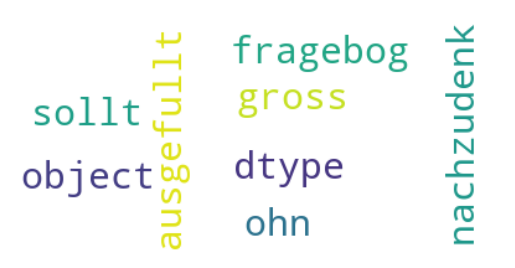

In [170]:
import wordcloud
import matplotlib.pyplot as plt
words  = pd.Series(" ".join(train['body_stem_nostop'].map(' '.join)))
wordcloud = wordcloud.WordCloud(max_font_size=30, max_words=200, background_color="white").generate(str(words)) #Generate Wordcloud
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis("off")
plt.show() #Show WordCloud.

In [171]:
from sklearn.feature_extraction.text import CountVectorizer
train['body_stem_nostop']  = train['body_stem_nostop'].map(' '.join)
pipeline = Pipeline(steps = [['Scaler',  CountVectorizer()],
                             ['classifier', LogisticRegressionCV()]])

cross_val_score(pipeline, train["body_stem_nostop"], train["category"], cv=5, scoring='balanced_accuracy').mean()

C:\Users\49157\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


KeyboardInterrupt: 

In [174]:
##Next: Load PreTrained German Word2Vec
import gensim.models.keyedvectors as word2vec
import gensim
import urllib.request 

urllib.request.urlretrieve('https://cloud.devmount.de/d2bc5672c523b086/german.model', 'word2vecgerman.model')
model = gensim.models.KeyedVectors.load_word2vec_format('./word2vecgerman.model', binary=True)

In [179]:
import numpy as np

words = set(model.index_to_key )
train["embedd"] = np.array([np.array([model[i] for i in ls if i in words])
                         for ls in train["body_stem_nostop"]])


C:\Users\49157\AppData\Local\Temp\ipykernel_3592\1982645855.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train["embedd"] = np.array([np.array([model[i] for i in ls if i in words])


In [180]:
train

Unnamed: 0                                               body  \
1173         6281  Der Fragebogen sollte ohne groß nachzudenken a...   
2946         4776  Kein Appetit, was bei 45 kg eher schlecht ist,...   
10741        3979  Huhu, vielen lieben Dank für die bekräftigende...   
306          7409  Aber wenn ich merke, dass ich mich selbst mit ...   
2086         5381  Ich habe mich tatsächlich auch auf das Stipend...   
...           ...                                                ...   
5218         2319  Wieso denkst du, dass er UNTERfordert ist? Er ...   
12252        5670  &gt;  Ich wollte nur freundlich sein\n\n*passi...   
1346         6284  Wenn es um das retardierte Medikament geht, st...   
11646        4982  vielleicht hilft dir das ja weiter\n\nhttps://...   
3582         3877  Erklärt meine Surfhistorie ziemlich gut, gleic...   

            category  wordcount  \
1173            ADHS          9   
2946            ADHS         53   
10741  depression_de         76   
306             ADHS        222   
2086            ADHS         56   
...              ...        ...   
5218            ADHS         16   
12252  depression_de          8   
1346            ADHS         52   
11646  depression_de          7   
3582            ADHS         13   

                                                body_low  \
1173   [der, fragebogen, sollte, ohne, groß, nachzude...   
2946   [kein, appetit, was, bei, 45, kg, eher, schlec...   
10741  [huhu, vielen, lieben, dank, für, die, bekräft...   
306    [aber, wenn, ich, merke, dass, ich, mich, selb...   
2086   [ich, habe, mich, tatsächlich, auch, auf, das,...   
...                                                  ...   
5218   [wieso, denkst, du, dass, er, unterfordert, is...   
12252  [gt, , ich, wollte, nur, freundlich, sein\n\np...   
1346   [wenn, es, um, das, retardierte, medikament, g...   
11646  [vielleicht, hilft, dir, das, ja, weiter\n\nht...   
3582   [erklärt, meine, surfhistorie, ziemlich, gut, ...   

                                            body_stemmed  \
1173   [der, fragebog, sollt, ohn, gross, nachzudenk,...   
2946   [kein, appetit, was, bei, 45, kg, eher, schlec...   
10741  [huhu, viel, lieb, dank, fur, die, bekraft, wo...   
306    [aber, wenn, ich, merk, dass, ich, mich, selb,...   
2086   [ich, hab, mich, tatsach, auch, auf, das, stip...   
...                                                  ...   
5218   [wieso, denk, du, dass, er, unterfordert, ist,...   
12252  [gt, , ich, wollt, nur, freundlich, sein\n\npa...   
1346   [wenn, es, um, das, retardiert, medikament, ge...   
11646  [vielleicht, hilft, dir, das, ja, weiter\n\nht...   
3582   [erklart, mein, surfhistori, ziemlich, gut, gl...   

                                        body_stem_nostop  \
1173   fragebog sollt ohn gross nachzudenk ausgefullt...   
2946   appetit 45 kg eher schlecht depression extrem ...   
10741  huhu lieb dank fur bekraft wort hast wahrschei...   
306    merk selb elvans kaum konzentri interessiert v...   
2086   tatsach stipendium beworb d\nich klein text ub...   
...                                                  ...   
5218   wieso denk unterfordert genauso uberfordert we...   
12252      gt  wollt freundlich sein\n\npassiv aggressiv   
1346   retardiert medikament geht stimmt jed fall ein...   
11646  vielleicht hilft ja weiter\n\nhttpswwwredditco...   
3582   erklart surfhistori ziemlich gut gleichmal che...   

                                                  embedd  
1173   [[-0.35495234, 0.0892258, -0.06375768, 0.20400...  
2946   [[-0.1018784, 0.103185415, -0.17899692, 0.3652...  
10741  [[-0.027431028, 0.15065025, 0.116400935, 0.144...  
306    [[-0.40094444, -0.0013827572, -0.20909877, -0....  
2086   [[-0.20596541, -0.063499026, 0.025930697, 0.18...  
...                                                  ...  
5218   [[-0.28657266, 0.1236175, 0.09868002, 0.021758...  
12252  [[-0.5052482, 0.27310663, 0.2589617, 0.2302302...  
1346   [[0.09821954, -0.073

In [181]:
# Compute sentence vectors by averaging the word vectors for the words contained in the sentence
train_vect_avg = []
for v in train["embedd"]:
    if v.size:
        train_vect_avg.append(v.mean(axis=0))
    else:
        train_vect_avg.append(np.zeros(100, dtype=float))

train["embedd_avg"] = train_vect_avg

In [192]:
train_vect_avg

[array([-1.54548183e-01,  7.98451602e-02,  6.65205717e-03,  1.74715057e-01,
         1.11467339e-01,  3.56905255e-03,  5.82376868e-02,  5.76232523e-02,
         1.14243813e-01, -5.49955619e-03,  1.42690361e-01,  4.62448443e-05,
        -1.14099033e-01,  2.53853381e-01, -2.00727522e-01, -7.05040917e-02,
        -2.63816565e-01, -6.47162870e-02,  3.95554423e-01,  1.03126252e-02,
        -5.43078035e-02, -1.83169022e-01,  1.70955777e-01, -1.96654975e-01,
        -1.52449552e-02,  2.93448959e-02,  2.12320566e-01, -1.65376872e-01,
         1.37148663e-01, -1.91864446e-02,  3.33964191e-02, -1.69753715e-01,
        -6.70249835e-02, -1.60218656e-01, -7.73514137e-02,  2.81068385e-02,
        -5.83221111e-03, -5.45408241e-02, -2.79653072e-01,  1.42775327e-01,
        -4.31205444e-02,  1.59856044e-02, -6.82747662e-02, -3.90270837e-02,
         9.76375714e-02, -1.22584298e-01, -8.13562945e-02, -3.30157764e-02,
         3.89411412e-02,  6.78370073e-02,  6.11919463e-02,  1.60120323e-01,
         2.0

In [193]:
from sklearn.linear_model import LogisticRegression

cross_val_score(LogisticRegression(), train_vect_avg, train["category"], cv=5, scoring='balanced_accuracy').mean()


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\49157\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\49157\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1196, in fit
    X, y = self._validate_data(
  File "C:\Users\49157\anaconda3\lib\site-packages\sklearn\base.py", line 565, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "C:\Users\49157\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 1106, in check_X_y
    X = check_array(
  File "C:\Users\49157\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 879, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "C:\Users\49157\anaconda3\lib\site-packages\sklearn\utils\_array_api.py", line 185, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (9004,) + inhomogeneous part.

--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\49157\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\49157\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1196, in fit
    X, y = self._validate_data(
  File "C:\Users\49157\anaconda3\lib\site-packages\sklearn\base.py", line 565, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "C:\Users\49157\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 1106, in check_X_y
    X = check_array(
  File "C:\Users\49157\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 879, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "C:\Users\49157\anaconda3\lib\site-packages\sklearn\utils\_array_api.py", line 185, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (9005,) + inhomogeneous part.


In [190]:
train["embedd_avg"].to_numpy()

array([array([-1.54548183e-01,  7.98451602e-02,  6.65205717e-03,  1.74715057e-01,
               1.11467339e-01,  3.56905255e-03,  5.82376868e-02,  5.76232523e-02,
               1.14243813e-01, -5.49955619e-03,  1.42690361e-01,  4.62448443e-05,
              -1.14099033e-01,  2.53853381e-01, -2.00727522e-01, -7.05040917e-02,
              -2.63816565e-01, -6.47162870e-02,  3.95554423e-01,  1.03126252e-02,
              -5.43078035e-02, -1.83169022e-01,  1.70955777e-01, -1.96654975e-01,
              -1.52449552e-02,  2.93448959e-02,  2.12320566e-01, -1.65376872e-01,
               1.37148663e-01, -1.91864446e-02,  3.33964191e-02, -1.69753715e-01,
              -6.70249835e-02, -1.60218656e-01, -7.73514137e-02,  2.81068385e-02,
              -5.83221111e-03, -5.45408241e-02, -2.79653072e-01,  1.42775327e-01,
              -4.31205444e-02,  1.59856044e-02, -6.82747662e-02, -3.90270837e-02,
               9.76375714e-02, -1.22584298e-01, -8.13562945e-02, -3.30157764e-02,
               3